# Setup

In [ ]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
#import cv2 as cv

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble  import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
feature_data_folder = './feature_data/'

In [83]:
#load all features & labels
#hog features
train_hog = np.load(feature_data_folder + 'hog/train_hog.npy')
#test_hog = np.load(feature_data_folder + 'hog/test_hog.npy')
val_hog = np.load(feature_data_folder + 'hog/val_hog.npy')

#resnet feature maps
train_resnet = np.load(feature_data_folder + 'resnet18/train-fmaps.npy')
#test_resnet = np.load(feature_data_folder + 'resnet18/test-fmaps.npy')
val_resnet = np.load(feature_data_folder + 'resnet18/val-fmaps.npy')

#sift features
train_glcm = np.load(feature_data_folder + 'glcm_scaled/train_glcm.npy')
#test_sift = np.load(feature_data_folder + 'sift/test_sift.npy')
val_glcm = np.load(feature_data_folder + 'glcm_scaled/val_glcm.npy')

#load labels
train_labels = np.load(feature_data_folder + 'resnet18/train-labels.npy')
test_labels = np.load(feature_data_folder + 'resnet18/test-labels.npy')
val_labels = np.load(feature_data_folder + 'resnet18/val-labels.npy')

In [12]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import models
from lightning import Trainer, LightningModule
import torchvision.transforms.functional as F
import webdataset as wds

In [4]:
def transform(image):
    # image = F.resize(image, 256)
    # image = F.center_crop(image, 224)
    image = np.array(image)
    image = F.to_tensor(image)
    image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return image

In [103]:
ds_train = (wds.WebDataset(f'file:{feature_data_folder}/corrected/train-000000.tar', shardshuffle=True)
    #.shuffle(5000)
    .decode("pil")
    .to_tuple("jpg", "json")
    .map(lambda row: (transform(row[0]), row[1]['label'] - 1)))

ds_val = (wds.WebDataset(f'file:{feature_data_folder}/corrected/val-000000.tar', shardshuffle=False)
    .decode("pil")
    .to_tuple("jpg", "json")
    .map(lambda row: (transform(row[0]), row[1]['label'] - 1)))

In [104]:
train_loader = DataLoader(ds_train, batch_size=64)
val_loader = DataLoader(ds_val, batch_size=64)

In [62]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, 7)

In [70]:
class SingleLayerModel(LightningModule):
    def __init__(self, resnet):
        super(SingleLayerModel, self).__init__()
        self.resnet = resnet

        imb = torch.tensor([0.2 , 0.91444498, 0.86245759, 0.8700921 , 0.96097916, 0.85203587, 0.91917111])
        self.loss_fn = nn.CrossEntropyLoss(weight=imb)

    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log(f"train_loss", loss, on_epoch=True, on_step=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log(f"val_loss", loss, on_epoch=True, on_step=True, prog_bar=True, logger=True)
        return loss

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        y = torch.softmax(self(x), dim=1)
        return y

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [71]:
model = SingleLayerModel(resnet)

In [72]:
trainer = Trainer(max_epochs=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [65]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | resnet  | ResNet           | 23.5 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
14.3 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.090    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\micha\miniconda3\envs\aer_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\micha\miniconda3\envs\aer_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: |          | 129/? [00:28<00:00,  4.49it/s, v_num=0, train_loss_step=0.152, val_loss_step=0.195, val_loss_epoch=0.691, train_loss_epoch=0.399]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 129/? [00:29<00:00,  4.42it/s, v_num=0, train_loss_step=0.152, val_loss_step=0.195, val_loss_epoch=0.691, train_loss_epoch=0.399]


In [111]:
preds = trainer.predict(model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\micha\miniconda3\envs\aer_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: |          | 44/? [00:07<00:00,  6.08it/s]


In [113]:
plabels = np.concatenate([torch.argmax(p, dim=1).numpy() for p in preds])

In [106]:
train_labels = [sample[1] for sample in ds_train]

In [112]:
ylabels = val_labels - 1

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'Count')

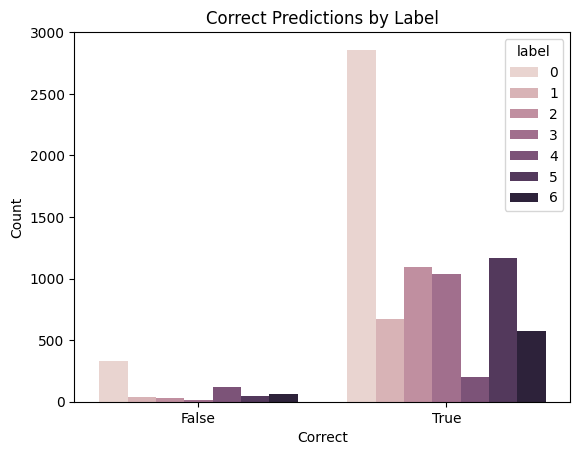

In [110]:
corr = plabels == ylabels
df_t = pd.DataFrame({'correct': corr, 'label': ylabels, 'plabel': plabels})
ax = sns.countplot(df_t, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

In [120]:
preds = np.concatenate([p.numpy() for p in preds])

In [126]:
spiders = list(df[df['label'] == 6].index)

In [129]:
spreds.shape

(203, 7)

In [128]:
spreds = preds[spiders]
spreds

array([[0.01457887, 0.15090278, 0.75560856, ..., 0.01987547, 0.02913751,
        0.02324833],
       [0.01203735, 0.12502076, 0.74710476, ..., 0.01457997, 0.07838318,
        0.01940808],
       [0.00550486, 0.01885811, 0.6487501 , ..., 0.00522281, 0.05546777,
        0.25348485],
       ...,
       [0.1526492 , 0.13210222, 0.2748048 , ..., 0.12387893, 0.14049365,
        0.11438742],
       [0.17685069, 0.13790236, 0.21941935, ..., 0.15579635, 0.13375388,
        0.13334142],
       [0.14021493, 0.24161845, 0.25874633, ..., 0.08078416, 0.06447688,
        0.16405107]], dtype=float32)

In [133]:
spreds.mean(axis=0)

array([0.14644542, 0.14064525, 0.30970696, 0.05870468, 0.0589261 ,
       0.1292697 , 0.15630195], dtype=float32)

In [146]:
losses = nn.functional.cross_entropy(torch.from_numpy(preds), torch.tensor(ylabels, dtype=torch.long), reduction='none').numpy()

In [147]:
df['loss'] = losses

<Axes: xlabel='loss', ylabel='Count'>

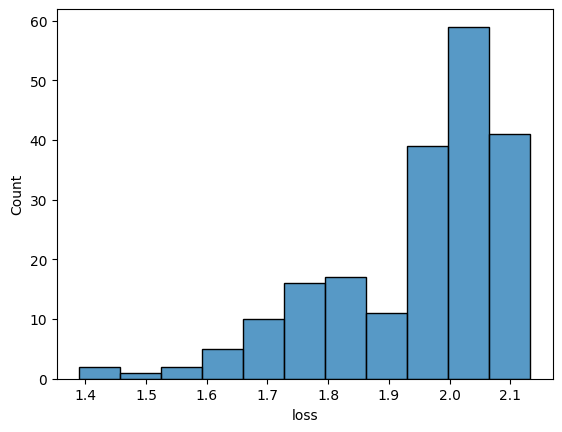

In [164]:
sns.histplot(df[df['label'] == 6], x='loss')

In [166]:
worst_spiders = list(df[df['label'] == 6].sort_values('loss', ascending=False).head().index)

In [177]:
best_spiders = list(df[df['label'] == 6].sort_values('loss', ascending=True).head().index)

In [178]:
worst_sp_imgs = val_images[worst_spiders]
best_sp_imgs = val_images[best_spiders]

In [167]:
val_labels[worst_spiders]

array([7, 7, 7, 7, 7], dtype=int32)

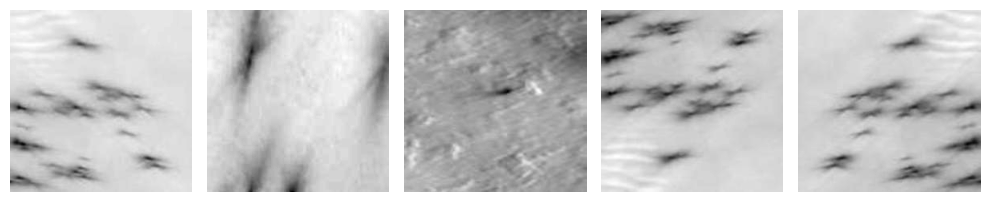

In [179]:
_, axs = plt.subplots(1, 5, figsize=(10, 5))
axs = axs.flatten()

for i, img in enumerate(best_sp_imgs):
    ax = axs[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [180]:
df[df['label'] == 6].sort_values('loss', ascending=False).head()

,correct,label,plabel,loss
370,False,6,1,2.133140
597,False,6,1,2.131779
286,False,6,2,2.124888
569,False,6,1,2.107365
281,False,6,2,2.105897


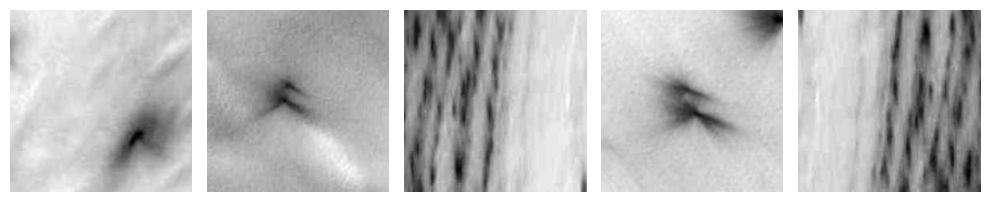

In [176]:
_, axs = plt.subplots(1, 5, figsize=(10, 5))
axs = axs.flatten()

for i, img in enumerate(worst_sp_imgs):
    ax = axs[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Count')

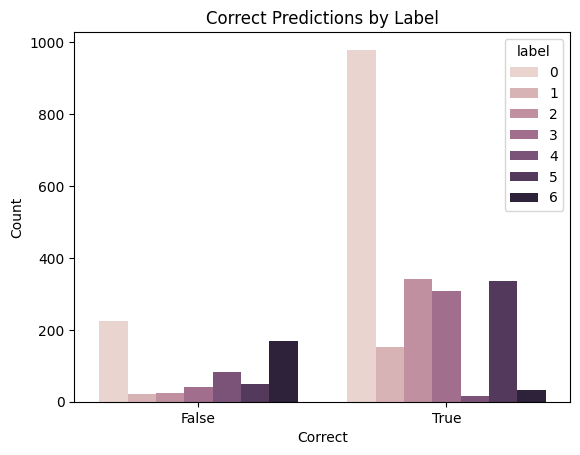

In [116]:
corr = plabels == ylabels
df = pd.DataFrame({'correct': corr, 'label': ylabels, 'plabel': plabels})
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

In [183]:
len(df[df['correct'] == True]) / len(df)

0.779337652987761

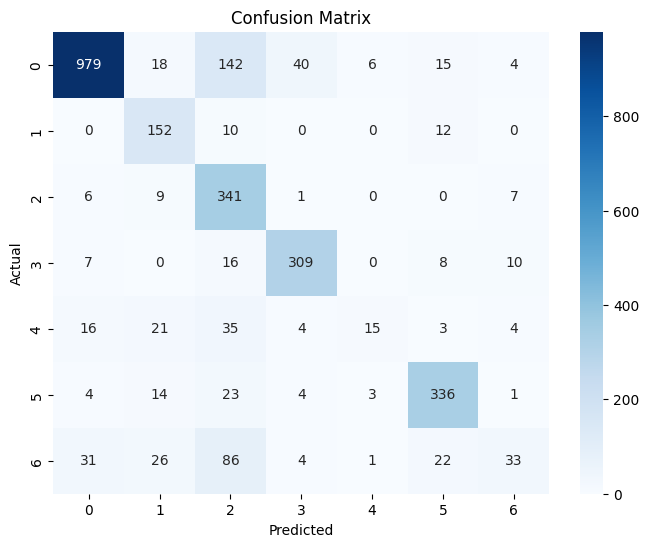

In [96]:
confusion_matrix = pd.crosstab(df['label'], df['plabel'], rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [4]:
print(train_hog.shape)
print(train_resnet.shape)
print(train_glcm.shape)
print(train_labels.shape)

(8252, 1296)
(8252, 512)
(8252, 5)
(8252,)


In [5]:
resnet_scaler = StandardScaler().fit(train_resnet)
hog_scaler = StandardScaler().fit(train_hog)
glcm_scaler = StandardScaler().fit(train_glcm)

train_resnet = resnet_scaler.transform(train_resnet)
train_hog = hog_scaler.transform(train_hog)
train_glcm = glcm_scaler.transform(train_glcm)

val_resnet = resnet_scaler.transform(val_resnet)
val_hog = hog_scaler.transform(val_hog)
val_glcm = glcm_scaler.transform(val_glcm)

In [11]:
#concat all features into 1d vector
train_features = np.concatenate((train_hog, train_resnet, train_glcm), axis = 1)
#test_features = np.concatenate((test_hog, test_resnet, test_sift), axis = 1)
val_features = np.concatenate((val_hog, val_resnet, val_glcm), axis = 1)

In [114]:
#2 feature testing
train_features_2 = np.concatenate((train_resnet, train_sift), axis = 1)
#test_features_2 = np.concatenate((test_resnet, test_sift), axis = 1)
val_features_2 = np.concatenate((val_resnet, val_sift), axis = 1)

# Baseline LR

In [6]:
clf = LogisticRegression(max_iter = 100).fit(train_hog, train_labels)

c:\Users\micha\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
clf.score(train_hog, train_labels)

0.9285021812893844

In [9]:
clf.score(val_hog, val_labels)

0.4143268538516919

In [56]:
preds = clf.predict(train_features)
corr = preds == train_labels

In [57]:
df = pd.DataFrame({'correct': corr, 'label': train_labels})

In [ ]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

# SVM

In [233]:
clf = HistGradientBoostingClassifier(
    max_iter=150,
    learning_rate=0.03,
    class_weight='balanced').fit(train_hog, train_labels)

In [51]:
clf = svm.SVC(class_weight = 'balanced')

In [52]:
clf = clf.fit(train_glcm, train_labels)

In [56]:
def validation_score(estimator, X, y):
    y_pred = estimator.predict(val_features_pca)
    return accuracy_score(val_labels, y_pred)

In [59]:
#param_grid={'C': [0.1,1,10,100] } 
param_grid={'C': [10,12.5,15] } 
clf = GridSearchCV(clf, param_grid, scoring=validation_score).fit(train_features_pca, train_labels)

In [60]:
clf.best_estimator_

SVC(C=10, class_weight='balanced')

In [66]:
train_features_pca.shape

(8960, 1250)

In [61]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [234]:
clf.score(train_hog, train_labels)

0.9923654871546291

In [235]:
clf.score(val_hog, val_labels)

0.6137508999280058

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ModuleNotFoundError: No module named 'sklearn'

In [19]:
preds = clf.predict(val_hog)
corr = preds == val_labels
df = pd.DataFrame({'correct': corr, 'y': val_labels, 'y_hat': preds})

In [18]:
import webdataset as wds

In [20]:
ids = list(df[(df['y'] == 3) & (df['y_hat'] == 1)].index)

In [152]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (
            np.array(row[0].convert('L')),
            row[1]
        )))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    #labels = np.array(labels)
    data.close()

    return images, labels

In [174]:
from skimage.transform import rescale

In [227]:
train_images = np.array([rescale(image, 1/2, mode='reflect') for image in train_images])
val_images = np.array([rescale(image, 1/2, mode='reflect') for image in val_images])

In [153]:
train_images, train_metas = load_data(f'file:{feature_data_folder}/corrected/train-000000.tar')
val_images, val_metas = load_data(f'file:{feature_data_folder}/corrected/val-000000.tar')

In [4]:
data = (wds.WebDataset(f'file:{feature_data_folder}/corrected/train-000000.tar', shardshuffle=True)
    .decode("pil")
    .to_tuple("jpg", "json"))

In [40]:
def gather(ds, items):
    found = []

    for i, res in enumerate(ds):
        if i in items:
            found.append(res)

    return found

In [281]:
bads = val_images[ids]

In [141]:
bads = np.array([cv.pyrDown(cv.pyrDown(bad)) for bad in bads])

In [157]:
train_images = np.array([cv.pyrDown(cv.pyrDown(image)) for image in train_images])
val_images = np.array([cv.pyrDown(cv.pyrDown(image)) for image in val_images])

In [41]:
bmetas = gather(val_metas, ids)

In [55]:
bmetas[2]

{'ttype': 'fv',
 'base': 'ESP_016570_2050_RED-0134.jpg',
 'label': 3,
 'image': 'ESP_016570_2050_RED-0134-fv.jpg'}

In [6]:
bads = gather(data, ids)

In [7]:
import matplotlib.pyplot as plt

In [25]:
import cv2 as cv
import numpy as np
from skimage.feature import hog

In [9]:
def downsize(img_dataset):
    downsized_dataset = []
    for i in range(len(img_dataset)):
        downsized_dataset.append(cv.pyrDown(img_dataset[i]))
    return np.array(downsized_dataset)

In [228]:
def get_hog_feature(imgs: list) -> tuple:
    hog_imgs = []
    hog_fts = []

    for img in imgs:
        #img = cv.GaussianBlur(img, (29, 29), 0)
        #img = cv.normalize(img, None, 0, 1, cv.NORM_MINMAX, cv.CV_32F)

        features, hog_img = hog(img, orientations=9, pixels_per_cell=(14, 14),
                        cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

        hog_imgs.append(hog_img)
        hog_fts.append(features)

    return np.array(hog_imgs), np.array(hog_fts)

def get_canny(imgs: list) -> tuple:
    canny_imgs = []

    for img in imgs:
        img = cv.GaussianBlur(img, (7, 7), 0)
        #img = cv.normalize(img, None, 0, 1, cv.NORM_MINMAX, cv.CV_32F)

        canny_img = canny(img, sigma=2.5)
        canny_imgs.append(canny_img.flatten())

    return np.array(canny_imgs)

def plot_hog_samples(sample_hogs: list, sample_labels: list):
    fig, axs = plt.subplots(nrows=2, ncols=len(sample_hogs) // 2, figsize=(15,5))
    axs = axs.ravel()

    samples = zip(sample_labels, sample_hogs)

    for i, (label, img) in enumerate(samples):
        ax = axs[i]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('HOG Features per Class')
    plt.show()

In [28]:
from skimage import exposure
from PIL import Image

In [27]:
def ah_equalize(img):
    img = np.array(img)
    img = exposure.equalize_adapthist(img) * 255
    img = img.astype(np.uint8)
    return Image.fromarray(img, mode='L')

In [230]:
_, train_hog = get_hog_feature(train_images)
_, val_hog = get_hog_feature(val_images)

In [195]:
train_edge = get_canny(train_images)
val_edge = get_canny(val_images)

In [196]:
scaler = StandardScaler().fit(train_edge)
train_edge = scaler.transform(train_edge)
val_edge = scaler.transform(val_edge)

In [189]:
from sklearn.linear_model import SGDClassifier

In [218]:
sgd_clf = svm.SVC(class_weight = 'balanced', kernel='rbf', max_iter=100)
sgd_clf.fit(train_edge, train_labels)

c:\Users\micha\miniconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(class_weight='balanced', max_iter=100)

In [219]:
sgd_clf.score(train_edge, train_labels)

0.137905962190984

In [220]:
sgd_clf.score(val_edge, val_labels)

0.08639308855291576

In [153]:
np.save(f'{feature_data_folder}/train_hog.npy', train_hog)
np.save(f'{feature_data_folder}/val_hog.npy', val_hog)

In [120]:
bad_imgs = [np.array(ah_equalize(img.convert('L'))) for img, _ in bads]

In [79]:
from skimage.feature import canny

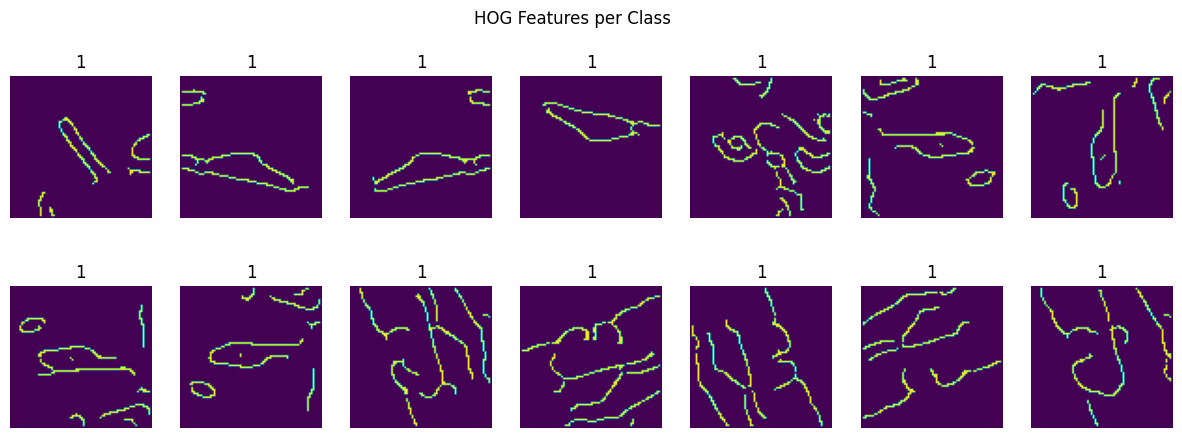

In [185]:
canny_bad = get_canny(bads[:14])
plot_hog_samples(canny_bad, [1] * len(canny_bad))

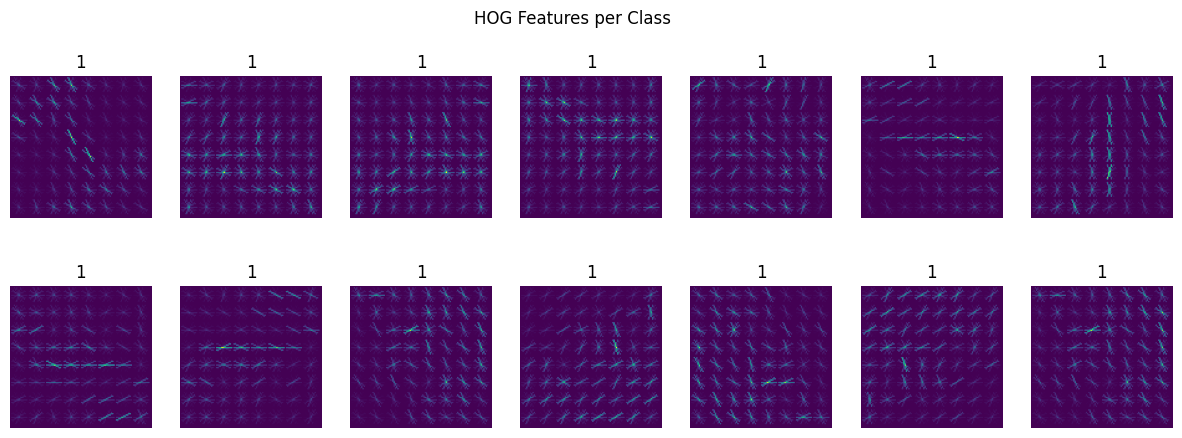

In [273]:
hog_bad, ft = get_hog_feature(bads[:14])
plot_hog_samples(hog_bad, [1] * len(hog_bad))

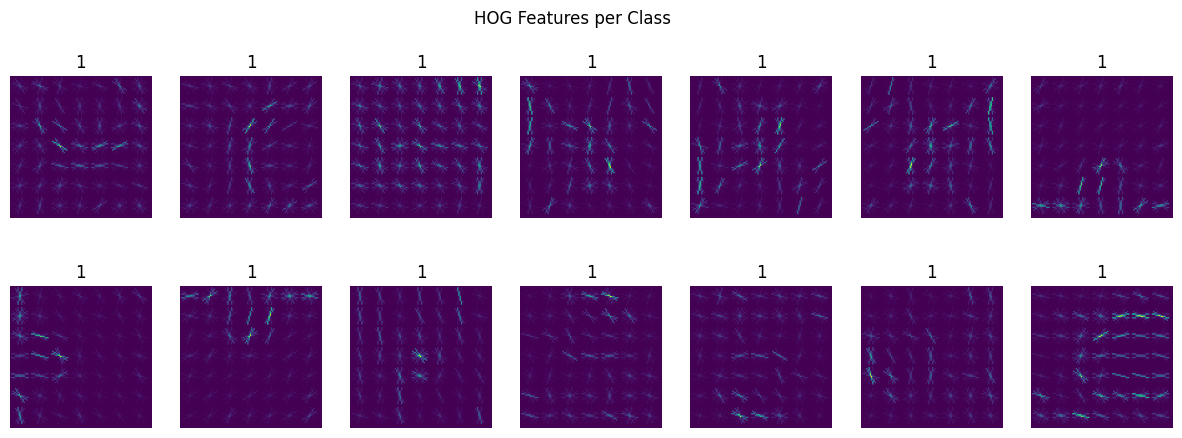

In [56]:
hog_bad, ft = get_hog_feature(bad_imgs)
plot_hog_samples(hog_bad, [1] * len(hog_bad))

In [279]:
# Function to compute Fourier transform features
def compute_fourier_features(image):
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift))
    return magnitude_spectrum

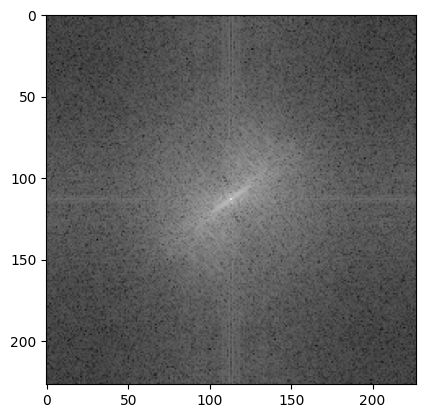

In [282]:
plt.imshow(compute_fourier_features(bads[0]), cmap='gray')

In [291]:
f_transform = np.fft.fft2(bads[0])
f_shift = np.fft.fftshift(f_transform)
# Create a circular mask
rows, cols = bads[0].shape
crow, ccol = rows // 2 , cols // 2
mask = np.zeros((rows, cols), np.uint8)
radius = 10 # Adjust the radius as needed
cv.circle(mask, (ccol, crow), radius, 1, thickness=-1)

# Apply the mask to the Fourier transform
f_shift_masked = f_shift * mask
# Inverse Fourier transform to get the image back
f_ishift = np.fft.ifftshift(f_shift_masked)
image_back = np.fft.ifft2(f_ishift)
image_back = np.abs(image_back)

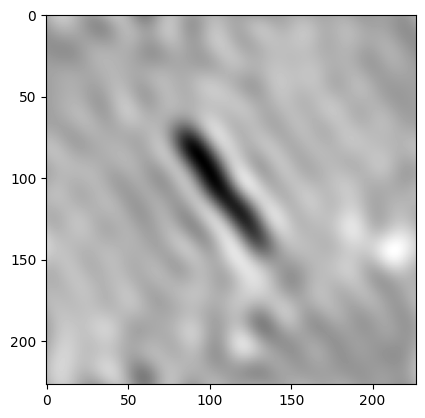

In [292]:
plt.imshow(image_back, cmap='gray')

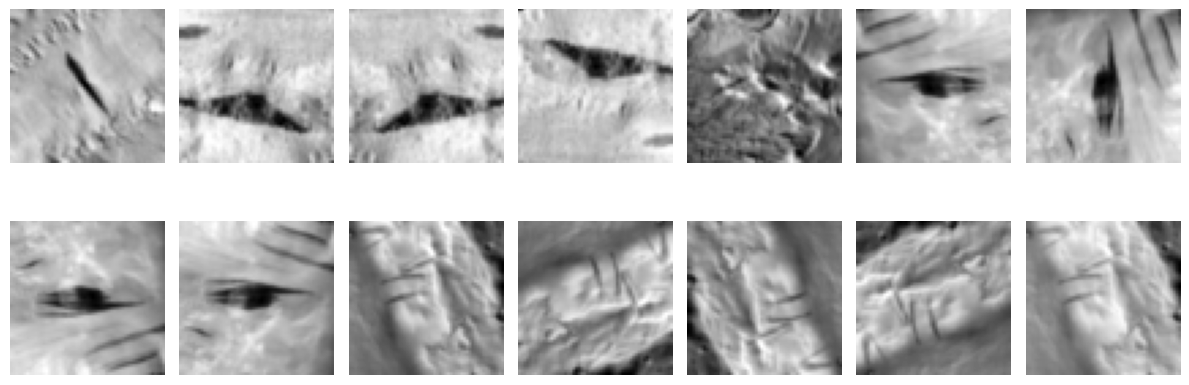

In [143]:
_, axs = plt.subplots(2, 7, figsize=(12, 5))
axs = axs.ravel()

for i, img in enumerate(bads[:14]):
    ax = axs[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

#plt.title('Incorrect training label 1 -> label 3')
plt.tight_layout()
plt.show()

In [246]:
from skimage import feature
from skimage import filters

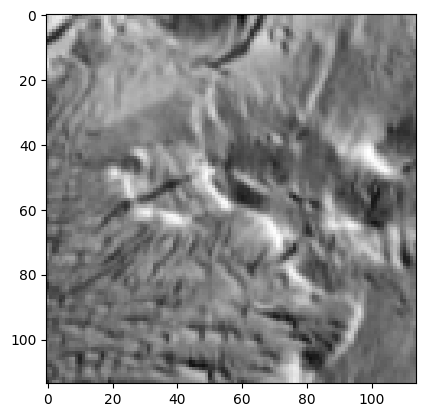

In [272]:
plt.imshow(filters.haar(bads[4]), cmap='gray')

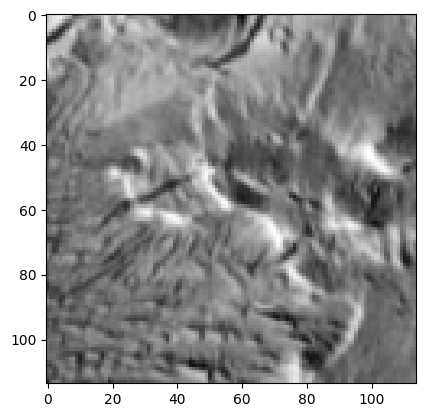

In [251]:
plt.imshow(bads[4], cmap='gray')

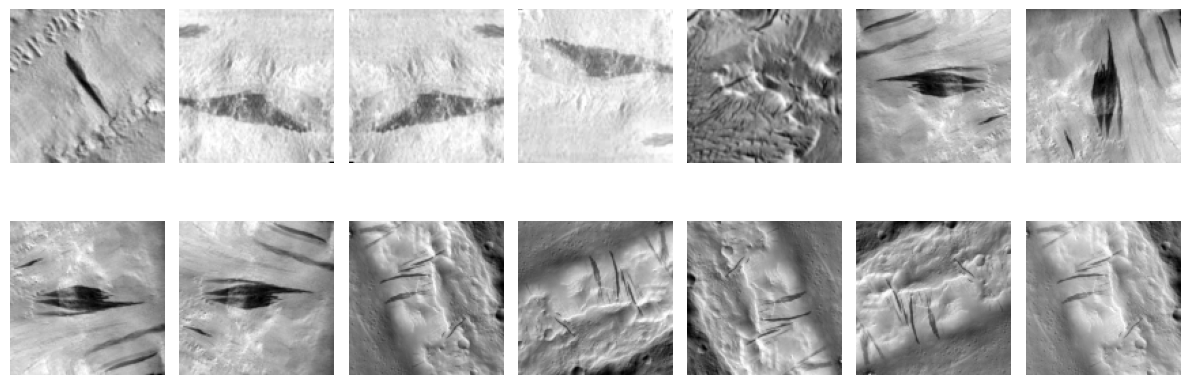

In [232]:
_, axs = plt.subplots(2, 7, figsize=(12, 5))
axs = axs.ravel()

for i, img in enumerate(bads[:14]):
    ax = axs[i]
    #img = np.array(ah_equalize(img.convert('L'))))
    ax.imshow(img, cmap='gray')
    ax.axis('off')

#plt.title('Incorrect training label 1 -> label 3')
plt.tight_layout()
plt.show()

In [237]:
cm_train = confusion_matrix(train_labels, clf.predict(train_hog))
cm_val = confusion_matrix(val_labels, clf.predict(val_hog))

In [28]:
ConfusionMatrixDisplay(cm_train).plot()

NameError: name 'ConfusionMatrixDisplay' is not defined

In [29]:
rep = [3129, 706, 1135, 1072, 322, 1221, 667]
tot = sum(rep)
pct = [p / tot for p in rep]

In [33]:
1 - np.array(pct)

array([0.6208192 , 0.91444498, 0.86245759, 0.8700921 , 0.96097916,
       0.85203587, 0.91917111])

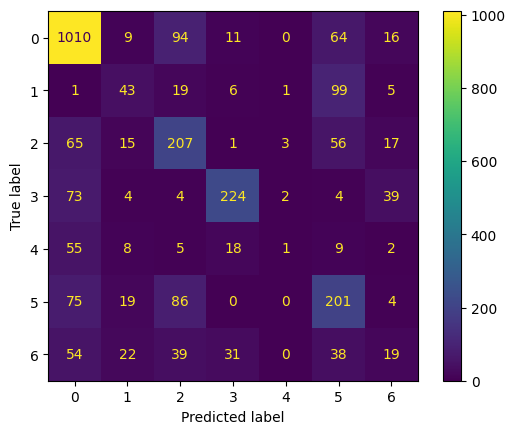

In [239]:
ConfusionMatrixDisplay(cm_val).plot()

In [31]:
majority_label = np.ones(val_labels.shape)
accuracy_score(val_labels, majority_label)

0.4334053275737941

Text(0, 0.5, 'Count')

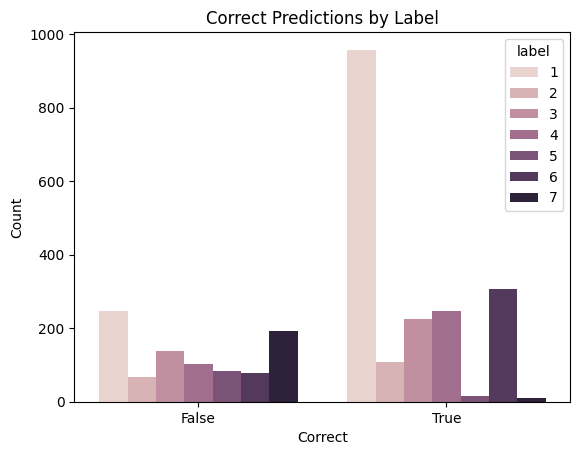

In [32]:
preds = clf.predict(val_features)
corr = preds == val_labels
df = pd.DataFrame({'correct': corr, 'label': val_labels})
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

## Class Rebalancing

In [ ]:
unique, counts = np.unique(train_labels, return_counts = True)
print(unique, counts) #min count is 343
min_label = min(counts)
print(min_label)

In [101]:
balanced_ids = []
for label in np.unique(train_labels):
    balanced_ids.append(np.where(train_labels == label)[0][:min_label])
balanced_ids = np.array(balanced_ids).flatten()
balanced_train_labels = train_labels[balanced_ids]
balanced_train_features = train_features[balanced_ids]

In [ ]:
print(balanced_train_labels.shape)
print(balanced_train_features.shape)

In [104]:
svc_clf = svm.SVC(class_weight = 'balanced').fit(balanced_train_features, balanced_train_labels)

In [ ]:
svc_clf.score(balanced_train_features, balanced_train_labels)

In [ ]:
svc_clf.score(val_features, val_labels)

In [ ]:
preds = svc_clf.predict(val_features)
corr = preds == val_labels
df = pd.DataFrame({'correct': corr, 'label': val_labels})
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

In [ ]:
#confusion matrix
cm = confusion_matrix(val_labels, preds, labels = svc_clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels = svc_clf.classes_)
disp.plot()
plt.show()

# Linear SVM

In [85]:
linear_svc = svm.LinearSVC().fit(train_features, train_labels)

In [ ]:
linear_svc.score(train_features, train_labels)

In [ ]:
linear_svc.score(val_features, val_labels)

# PCA

In [33]:
pca = PCA()
pca.fit(train_features)

PCA()

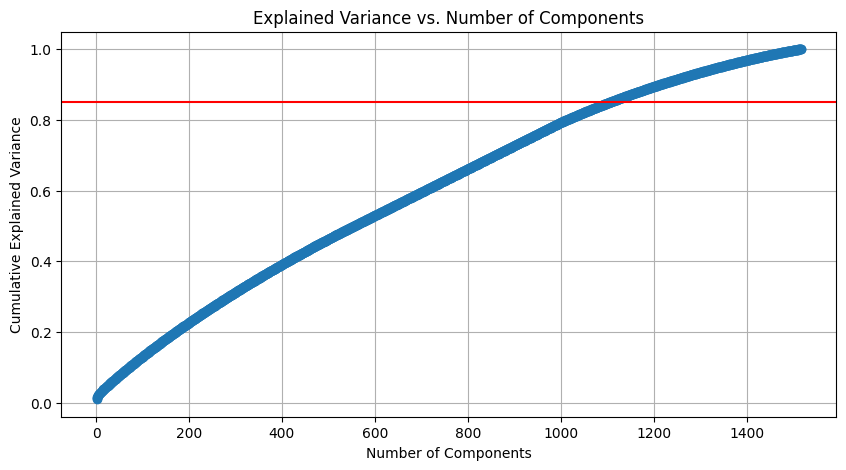

In [34]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 90% of explained variance
plt.axhline(y=0.85, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [35]:
pca = PCA(n_components=1200)
pca.fit(train_features)

PCA(n_components=1200)

In [36]:
train_features_pca = pca.transform(train_features)
val_features_pca = pca.transform(val_features)
#test_features_pca = pca.transform(test_features)

In [136]:
svc_clf = svm.SVC(class_weight = 'balanced').fit(train_features_pca, train_labels)

In [ ]:
svc_clf.score(train_features_pca, train_labels)

In [ ]:
svc_clf.score(val_features_pca, val_labels)